In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

Cargar el archivo

In [ ]:
# Leer 0 para leer todo el archivo, 1 para cargar un data frame que ya haya leido el archivo
Leer = 1
if Leer == 0:
    # Leer el archivo ignorando el encabezado, 9 skiprows
    dfs = [pd.read_csv(f"Datos\Toma_nueva_reflector\Original_Toma_M1_1h\Run{i}_list.txt", delim_whitespace=True, skiprows=9, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], engine="python") for i in range(1,30)]

    df = pd.concat(dfs, ignore_index=True)
    df.to_parquet('Datos\Toma_nueva_reflector\Original_Toma_M1_1h\Toma_datos_1h.parquet')

else:
    df = pd.read_parquet('Datos\Toma_nueva_reflector\Toma_M1_1h\Toma_datos_1h.parquet', engine='pyarrow')


#df = pd.read_csv("Datos\Toma_M1_10min\Run1_list.txt", delim_whitespace=True, skiprows=9, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], engine="python")
df  

,Brd,Ch,LG,HG,Tstamp_us,TrgID,NHits
0,0,0,2578,4019,19900.064,0.0,64.0
1,0,1,3124,3993,NaN,NaN,NaN
2,0,2,3838,4046,NaN,NaN,NaN
3,0,3,4057,4052,NaN,NaN,NaN
4,0,4,4065,4049,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5047035,0,59,51,277,NaN,NaN,NaN
5047036,0,60,412,3806,NaN,NaN,NaN
5047037,0,61,27,30,NaN,NaN,NaN
5047038,0,62,35,33,NaN,NaN,NaN


Graficar los valores de ADC para visualizar sucomportamiento

Text(0.5, 1.0, 'Valores ADC LG filtrado')

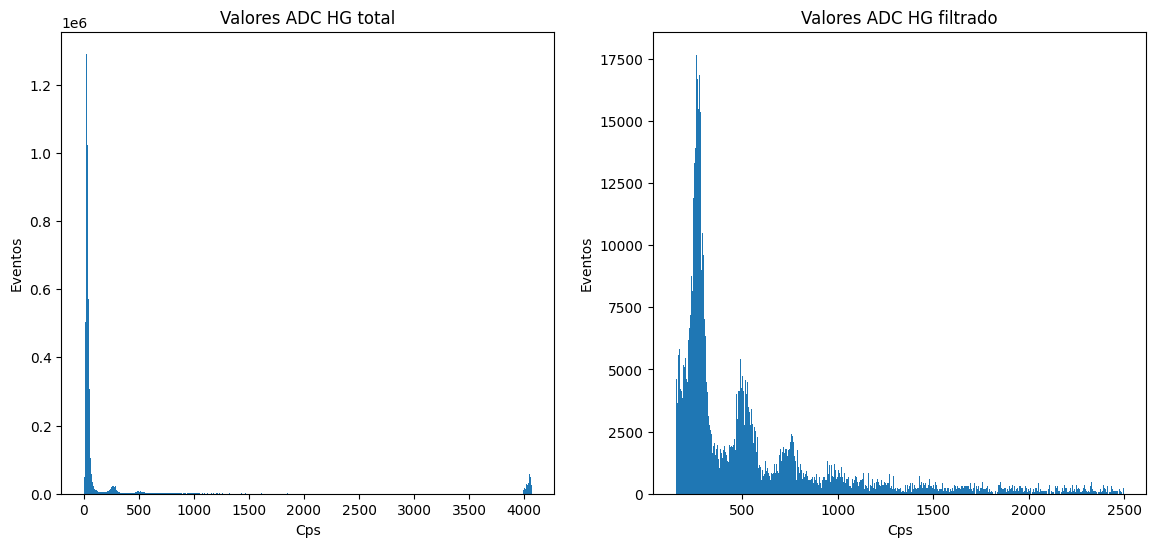

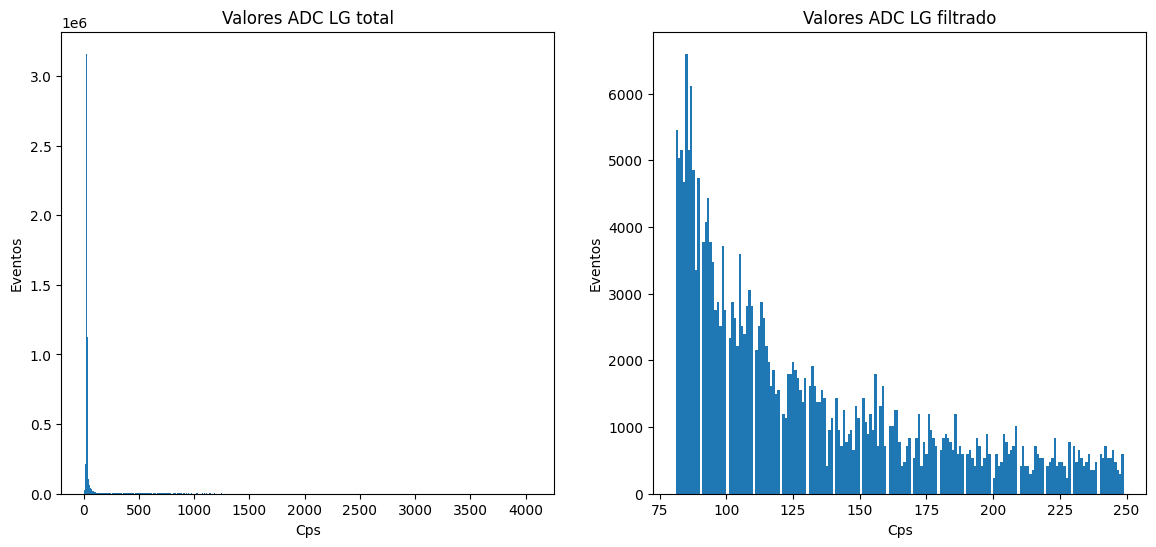

In [50]:
df_fil =df[df["HG"]<2500]
df_fil =df_fil[df_fil["HG"]>150]

df_fil2 =df[df["LG"]<250]
df_fil2 =df_fil2[df_fil2["LG"]>80]

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 6))
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6))

ax1[0].hist(df["HG"], bins=1000)
ax1[0].set_xlabel("Cps")
ax1[0].set_ylabel("Eventos")
ax1[0].set_title("Valores ADC HG total")

ax1[1].hist(df_fil["HG"], bins=800)
ax1[1].set_xlabel("Cps")
ax1[1].set_ylabel("Eventos")
ax1[1].set_title("Valores ADC HG filtrado")

ax2[0].hist(df["LG"], bins=1000)
ax2[0].set_xlabel("Cps")
ax2[0].set_ylabel("Eventos")
ax2[0].set_title("Valores ADC LG total")

ax2[1].hist(df_fil2["LG"], bins=185)
ax2[1].set_xlabel("Cps")
ax2[1].set_ylabel("Eventos")
ax2[1].set_title("Valores ADC LG filtrado")

Función de Eficiencia

In [2]:
# funcion secundaria para discriminar eventos reales para activaciones triples y cudruples con adyacencia 
def conteo(df, cuadru, tripl, count, n_counts): # Dataframe, cuadruples, triples, lista de canales activados local, lista número de canales activados global, HG/LG, i-ésimo disparo
    
    n = len(count) # núm. canales activados
    #n_counts.append(n)
    
    # Discrimina rondas con cuadruples y que esten juntos cada pareja
    if n == 4:
        if count[0] == count[1] -1 and count[2] == count[3] - 1 and count[1]<=28 and count[2]>=32:
        
            # Parado desde cada canal, nota que él mismo, uno contiguo y otro 2 en el otro eje
            cuadru[count[0]] += 1
            cuadru[count[1]] += 1
            cuadru[count[2]] += 1
            cuadru[count[3]] += 1
            
            n_counts.append(n)
            
        #else:
            #error_count.append(count)
            
    # Discrimina rondas de triples
    elif n==3:
        # Discrimina si los canales están pegados en el eje X y el tercero pertenece al eje y
        if count[0] == count[1] - 1 and count[1] != count[2] - 1 and (count[1] <= 28 and count[2] >= 32):
            
            # Son triples aquellos contiguos al canal en y al no tener pareja
            # Condicionar para problema de bordes
            if count[2] > 32:
                tripl[count[2] -1] += 1
            if count[2] < 60:
                tripl[count[2] +1] += 1

            n_counts.append(n)
            
        # Discrimina si los canales están pegados en el eje Y y el primero pertenece al eje x
        elif count[0] != count[1] - 1 and count[1] == count[2] - 1 and (count[0] <= 28 and count[2] >= 32):
            
            # Son triples aquellos contiguos al canal en x al no tener pareja
            # Condicionar para problema de bordes
            if count[0] > 0:
                tripl[count[0] -1] += 1
            if count[0] < 28:
                tripl[count[0] +1] += 1
                
            n_counts.append(n)
        
        #else:
            #error_count.append(count)
    
    return cuadru, tripl, n_counts


def eficiencias(df, td_hg, td_lg):
    
    # Diccionarios para 3-activaciones y 4-activaciones {canal:contador} para HG y LG
    triples_h = {}
    cuadruples_h = {}
    triples_l = {}
    cuadruples_l = {}
    triples_b = {}
    cuadruples_b = {}

    # Conteos totales por disparo {Núm.canales:contador}
    conteo_total_h = {}
    conteo_total_l = {}
    conteo_total_b = {}

    # Se llenan los disccionarios
    for i in range(64):
        triples_h[i]= 0
        cuadruples_h[i] = 0
        triples_l[i]= 0
        cuadruples_l[i] = 0
        triples_b[i]= 0
        cuadruples_b[i] = 0

        conteo_total_h[i] = 0
        conteo_total_l[i] = 0
        conteo_total_b[i] = 0
    
    # Tambien se pueden activar 64 canales
    conteo_total_h[64] = 0
    conteo_total_l[64] = 0
    conteo_total_b[64] = 0
    
    # Lista de cantidad de canales activados por disparo con HG y LG
    n_counts_h= [] 
    n_counts_l= [] 
    n_counts_b= [] 
    
    # Recorre cada ronda de activación - i-ésima ronda
    for i in range(int(len(df)/64)):
        
        # Lista de los canales activos para aquellos discriminados en funcion de el HG, LG o b-ambos
        hg_count = []
        lg_count = []
        b_count = []
        
        # Recorre todos los canales de la ronda de activación - j-ésimo canal de la i-ésimo disparo
        for j in range(64):
            
            # Valor del H/L gain
            hg = df["HG"].values[i*64 + j]
            lg = df["LG"].values[i*64 + j]

            # Discrimina y agrega el canal a la lista de canales activados
            if hg > td_hg and lg > td_lg:
                hg_count.append(j)
                lg_count.append(j)
                b_count.append(j)
            else:
                if hg > td_hg:
                    hg_count.append(j)
                if lg > td_lg:
                    lg_count.append(j)
        
        # Agrega cantidad de canales activados en el disparo
        conteo_total_h[len(hg_count)] += 1
        conteo_total_l[len(lg_count)] += 1
        conteo_total_b[len(b_count)] += 1
        
        conteo_total = [conteo_total_h,conteo_total_l,conteo_total_b]
        
        # Para cada tipo HG/LG/Both se determinará los conteos cuadruples y triples del i-ésimo disparo
        datos_h = conteo(df, cuadruples_h, triples_h, hg_count, n_counts_h) 
        datos_l = conteo(df, cuadruples_l, triples_l, lg_count, n_counts_l)
        datos_b = conteo(df, cuadruples_b, triples_b, b_count, n_counts_b)
        
    #Corrección geométrica
    correc_exe = [1,27,33,59] #canales que corregir al considerar exceso de triples
    for i in correc_exe:
        datos_h[1][i] /= 2
        datos_l[1][i] /= 2
        datos_b[1][i] /= 2
        
    return datos_h, datos_l, datos_b, conteo_total

Determinar el Threshold para HG y LG en valores de ADC

In [9]:
# Se ejecuta la eficiencia para una variedad de Threshold

#df = pd.read_csv("Datos\Toma_M1_1h\Run1_list.txt", delim_whitespace=True, skiprows=9, names=["Brd", "Ch", "LG", "HG", "Tstamp_us", "TrgID", "NHits"], engine="python")
df = pd.read_parquet('Datos\Toma_nueva_reflector\Toma_M1_1h\Toma_datos_1h.parquet', engine='pyarrow')
total = []
for t_hg in range(100,2500,50):
    t_lg = t_hg/5
    
    total.append(eficiencias(df, t_hg,t_lg))
    
# Guarda el archivo
with open("Datos\Toma_nueva_reflector\Toma_M1_1h\Variacion_TD.pkl", "wb") as f:
    pickle.dump(total, f)
    
df = pd.read_parquet('Datos\Toma_nueva_reflector\Toma_M2_1h\Toma_datos_1h.parquet', engine='pyarrow')
total = []
for t_hg in range(100,2500,50):
    t_lg = t_hg/5
    
    total.append(eficiencias(df, t_hg,t_lg))
    
# Guarda el archivo
with open("Datos\Toma_nueva_reflector\Toma_M2_1h\Variacion_TD.pkl", "wb") as f:
    pickle.dump(total, f)

In [18]:
# Carga el archivo de la variedad de eficiencias por threshold 
with open("Datos\Toma_M1_1h\Variacion_TD.pkl", "rb") as f:
    total_cargado_1 = pickle.load(f)

with open("Datos\Toma_M2_1h\Variacion_TD.pkl", "rb") as f:
    total_cargado_2 = pickle.load(f)

Cantidad de 3-activaciones y 4-activaciones en funcion del threshold

'ax[1].scatter(Td_lg_list, n_l_4, color=\'red\', s=30, label="4 ch activados")\nax[1].scatter(Td_lg_list, n_l_3, color=\'blue\', s=30, label="3 ch activados")\nax[1].plot(Td_lg_list, n_l_4, "--r")\nax[1].plot(Td_lg_list, n_l_3, "--b")\nax[1].set_xlabel("Threshold LG ADC")\nax[1].set_ylabel("Cantidad de eventos con 3-4 canales activados")\nax[1].set_title("Número de canales prendidos vs Threshold LG")\nax[1].legend()'

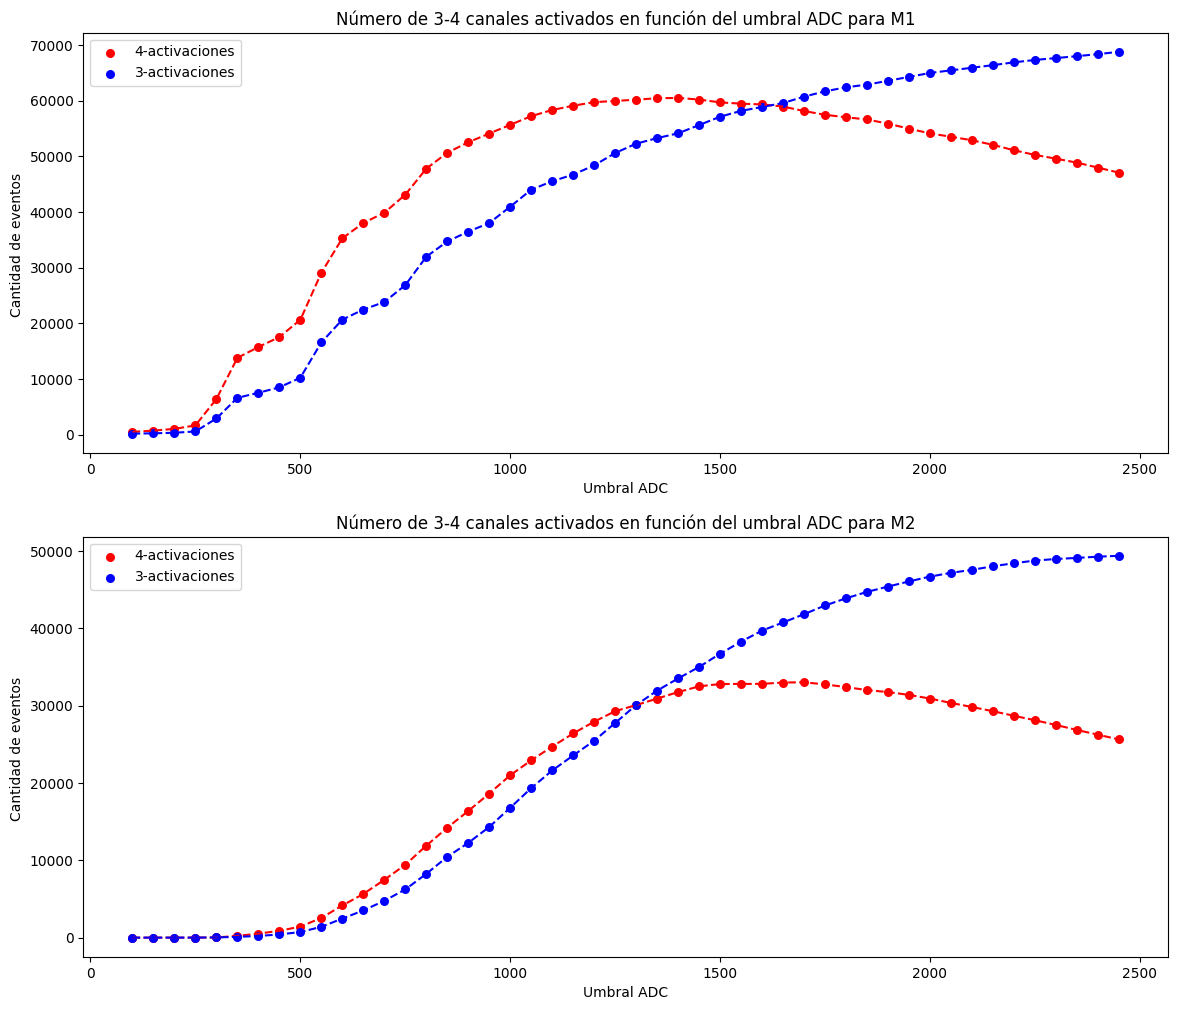

In [ ]:
# Lista de los valores de threshold
Td_hg_list_1 = np.arange(100, 2500, 50)
Td_lg_list_1 = Td_hg_list_1/5

Td_hg_list_2 = np.arange(100, 2500, 50)
Td_lg_list_2 = Td_hg_list_2/5

# Lista del número de 3-4-activaciones por threshold en HG
n_h_4_1 = []
n_h_3_1 = []

n_h_4_2 = []
n_h_3_2 = []

# Lista del número de 3-4-activaciones por threshold en LG
n_l_4_1 = []
n_l_3_1 = []

n_l_4_2 = []
n_l_3_2 = []

# Recorre todas las eficiencias y obtiene el n_count_HG/LG
for run in total_cargado_1:
    
    # .count cuenta los elementos que tiene n_count con valor de 4-3
    n_h_4_1.append(run[0][2].count(4))
    n_h_3_1.append(run[0][2].count(3))
    
    n_l_4_1.append(run[1][2].count(4))
    n_l_3_1.append(run[1][2].count(3))
    
for run in total_cargado_2:
    
    # .count cuenta los elementos que tiene n_count con valor de 4-3
    n_h_4_2.append(run[0][2].count(4))
    n_h_3_2.append(run[0][2].count(3))

    n_l_4_2.append(run[1][2].count(4))
    n_l_3_2.append(run[1][2].count(3))
    
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

ax[0].scatter(Td_hg_list_1, n_h_4_1, color='red', s=30, label="4-activaciones")
ax[0].scatter(Td_hg_list_1, n_h_3_1, color='blue', s=30, label="3-activaciones")
ax[0].plot(Td_hg_list_1, n_h_4_1, "--r")
ax[0].plot(Td_hg_list_1, n_h_3_1, "--b")
ax[0].set_xlabel("Umbral ADC")
ax[0].set_ylabel("Cantidad de eventos ")
ax[0].set_title("Número de 3-4 canales activados en función del umbral ADC para M1")
ax[0].legend()

ax[1].scatter(Td_hg_list_2, n_h_4_2, color='red', s=30, label="4-activaciones")
ax[1].scatter(Td_hg_list_2, n_h_3_2, color='blue', s=30, label="3-activaciones")
ax[1].plot(Td_hg_list_2, n_h_4_2, "--r")
ax[1].plot(Td_hg_list_2, n_h_3_2, "--b")
ax[1].set_xlabel("Umbral ADC")
ax[1].set_ylabel("Cantidad de eventos ")
ax[1].set_title("Número de 3-4 canales activados en función del umbral ADC para M2")
ax[1].legend()

Eficiencias en función de Threshold

Text(0.5, 1.0, 'Eficiencia promedio en función Threshold LG')

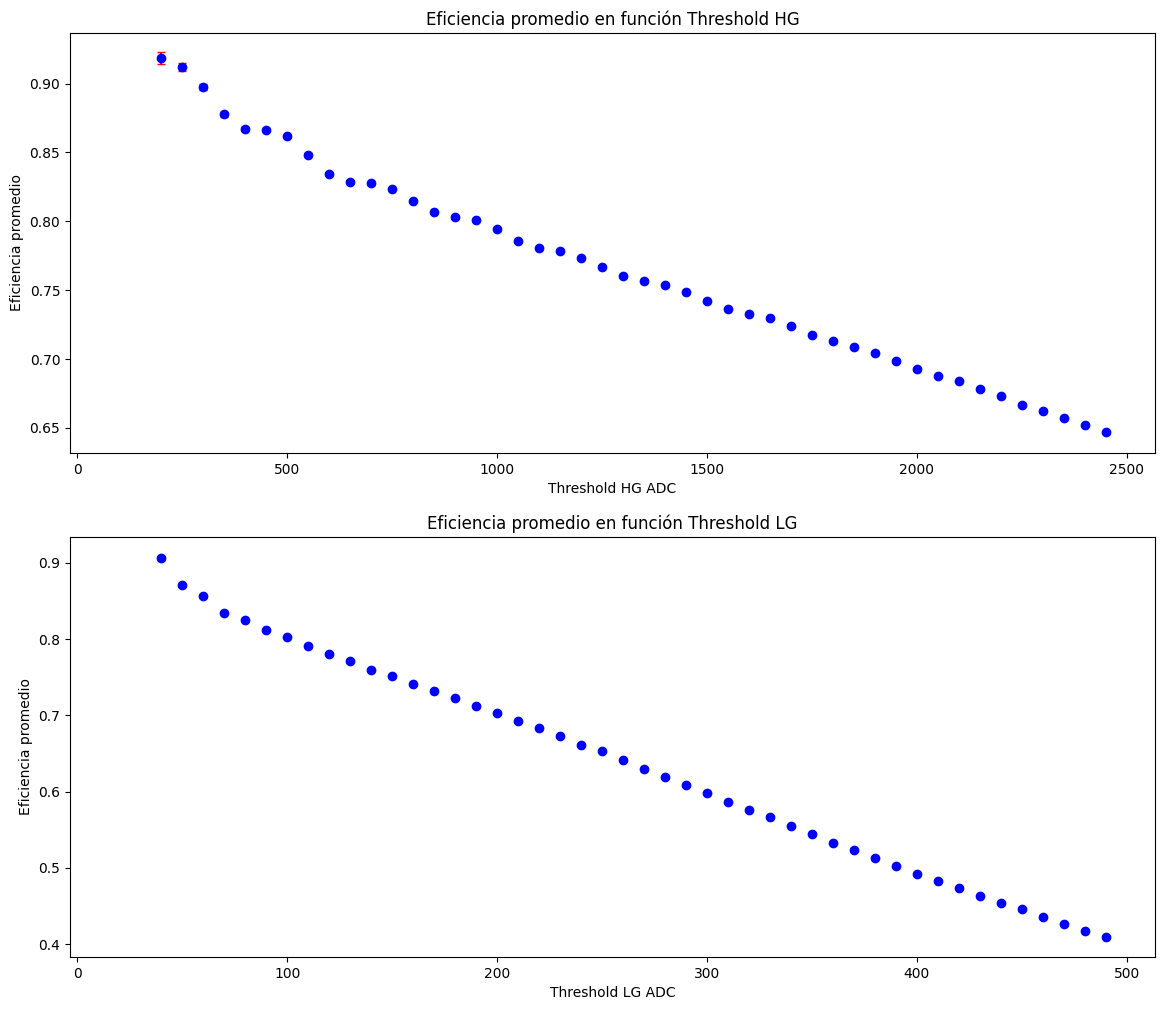

In [7]:
# Listas de eficiencis en funcion de threshold
eficiencia_h = []
eficiencia_l = []
err_eficiencia_h = []
err_eficiencia_l = []

# Funcion secundaria para obtener el promedio ponderado al obtener la lista de eficiencias
def promedio_ponderado(valores, errores):
    pesos = 1 / np.array(errores)**2
    promedio = np.sum(pesos * valores) / np.sum(pesos)
    error_promedio = np.sqrt(1 / np.sum(pesos))
    return promedio, error_promedio

# Recorre las eficiencias
for run in total_cargado:
    # Por cada disparo obtiene los triples y cuadruples. Los valores de _ no son utiles por ahora
    cuadri_h, triple_h, *_ = run[0]
    cuadri_l, triple_l, *_ = run[1]
    
    # Convierte los diccionarios en array de sus valores donde el indice será la barra respectiva
    cuadri_h = np.array(list(cuadri_h.values()))
    triple_h = np.array(list(triple_h.values()))
    cuadri_l = np.array(list(cuadri_l.values()))
    triple_l = np.array(list(triple_l.values()))
    
    # codigo para evitar warnings al dividir por 0: esto da un valor Nan
    with np.errstate(divide='ignore', invalid='ignore'):
        
        # Se calcula la eficiencia
        eff_h = cuadri_h/(triple_h+cuadri_h)
        eff_l = cuadri_l/(triple_l+cuadri_l)
        
        # Se calcula el error de la eficiencia
        err_efi_h = np.sqrt(cuadri_h*((triple_h/(cuadri_h+triple_h)**2))**2 + triple_h*((cuadri_h/(cuadri_h+triple_h)**2))**2)
        err_efi_l = np.sqrt(cuadri_l*((triple_l/(cuadri_l+triple_l)**2))**2 + triple_l*((cuadri_l/(cuadri_l+triple_l)**2))**2)
        
        # Se eliminan los elementos Nan (Estos son los canales apagados, el indice no importa ya que se calculará 
        # el promedio y el error asociado tambien tendrá la misma posición)
        efi_h = eff_h[~np.isnan(eff_h)]
        efi_l = eff_l[~np.isnan(eff_l)]
        err_h = err_efi_h[~np.isnan(err_efi_h)]
        err_l = err_efi_l[~np.isnan(err_efi_l)]

        # se calcula los promedios ponderados y su error asociado
        prom_h, err_prom_h = promedio_ponderado(efi_h, err_h)
        prom_l, err_prom_l = promedio_ponderado(efi_l, err_l)
    
    # Se agregan las eficiencias y su error
    eficiencia_h.append(prom_h)
    eficiencia_l.append(prom_l)
    err_eficiencia_h.append(err_prom_h)
    err_eficiencia_l.append(err_prom_l)

fig, ax = plt.subplots(2, 1, figsize=(14, 12))

ax[0].errorbar(Td_hg_list, eficiencia_h, yerr=err_eficiencia_h, fmt='o', color='blue', ecolor='red', capsize=3)
ax[0].set_xlabel("Threshold HG ADC")
ax[0].set_ylabel("Eficiencia promedio")
ax[0].set_title(f"Eficiencia promedio en función Threshold HG")

ax[1].errorbar(Td_lg_list, eficiencia_l, yerr=err_eficiencia_l, fmt='o', color='blue', ecolor='red', capsize=3)
ax[1].set_xlabel("Threshold LG ADC")
ax[1].set_ylabel("Eficiencia promedio")
ax[1].set_title(f"Eficiencia promedio en función Threshold LG")


Cálculo de Eficiencia con threshold apropiado

In [5]:
td_hg, td_lg = 1000, 150
df = pd.read_parquet('Datos\Toma_nueva_reflector\Final_Toma_M1_1h\Toma_datos_1h.parquet', engine='pyarrow')
datos_h, datos_l, datos_b, conteo_total = eficiencias(df, td_hg, td_lg)
cuadruples_h, triples_h, n_counts_h = datos_h
cuadruples_l, triples_l, n_counts_l = datos_l
cuadruples_b, triples_b, n_counts_b = datos_b
conteo_total_h, conteo_total_l, conteo_total_b = conteo_total

df2 = pd.read_parquet('Datos\Toma_nueva_reflector\Final_Toma_M2_1h\Toma_datos_1h.parquet', engine='pyarrow')
datos_h2, datos_l2, datos_b2, conteo_total2 = eficiencias(df2, td_hg, td_lg)
cuadruples_h2, triples_h2, n_counts_h2 = datos_h2
cuadruples_l2, triples_l2, n_counts_l2 = datos_l2
cuadruples_b2, triples_b2, n_counts_b2 = datos_b2
conteo_total_h2, conteo_total_l2, conteo_total_b2 = conteo_total2

Graficamos la cantidad activaciones por canal

'ax[1].scatter(list(conteo_total_l.keys()), list(conteo_total_l.values()))\nax[1].axhline(y=conteo_total_l[3], color=\'red\', linestyle=\'--\', label=f\'triples = {conteo_total_l[3]}\')\nax[1].axhline(y=conteo_total_l[4], color=\'black\', linestyle=\'--\', label=f\'cuadruples = {conteo_total_l[4]}\')\nax[1].set_xlabel("Número de canales prendidos")\nax[1].set_ylabel("Cantidad de disparos")\nax[1].set_title(f"Número de canales prendidos bajo discriminador LG: {td_lg}")\nax[1].legend()\n\nax[2].scatter(list(conteo_total_b.keys()), list(conteo_total_b.values()))\nax[2].axhline(y=conteo_total_b[3], color=\'red\', linestyle=\'--\', label=f\'triples = {conteo_total_b[3]}\')\nax[2].axhline(y=conteo_total_b[4], color=\'black\', linestyle=\'--\', label=f\'cuadruples = {conteo_total_b[4]}\')\nax[2].set_xlabel("Número de canales prendidos")\nax[2].set_ylabel("Cantidad de disparos")\nax[2].set_title(f"Número de canales prendidos bajo discriminador HG y LG: {td_hg} y {td_lg}")\nax[2].legend()'

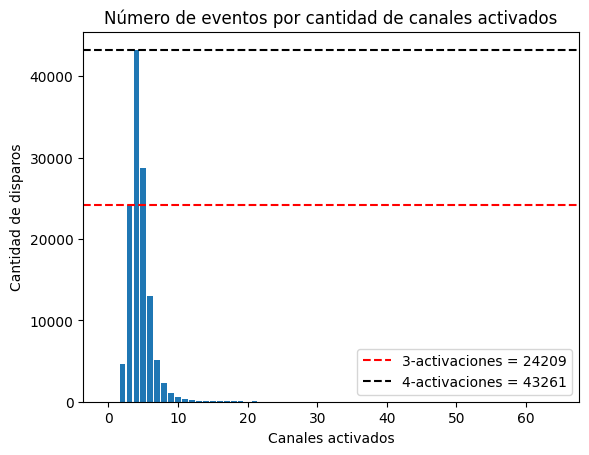

In [ ]:
plt.bar(list(conteo_total_h.keys()), list(conteo_total_h.values()))
plt.axhline(y=conteo_total_h[3], color='red', linestyle='--', label=f'3-activaciones = {conteo_total_h[3]}')
plt.axhline(y=conteo_total_h[4], color='black', linestyle='--', label=f'4-activaciones = {conteo_total_h[4]}')
plt.title("Número de eventos por cantidad de canales activados")
plt.xlabel("Canales activados")
plt.ylabel("Cantidad de disparos")
#plt.yscale('log')
plt.legend()

"""
ax[1].scatter(list(conteo_total_l.keys()), list(conteo_total_l.values()))
ax[1].axhline(y=conteo_total_l[3], color='red', linestyle='--', label=f'triples = {conteo_total_l[3]}')
ax[1].axhline(y=conteo_total_l[4], color='black', linestyle='--', label=f'cuadruples = {conteo_total_l[4]}')
ax[1].set_xlabel("Número de canales prendidos")
ax[1].set_ylabel("Cantidad de disparos")
ax[1].set_title(f"Número de canales prendidos bajo discriminador LG: {td_lg}")
ax[1].legend()
"""

calculo de eficiencias

92670 114218 114218


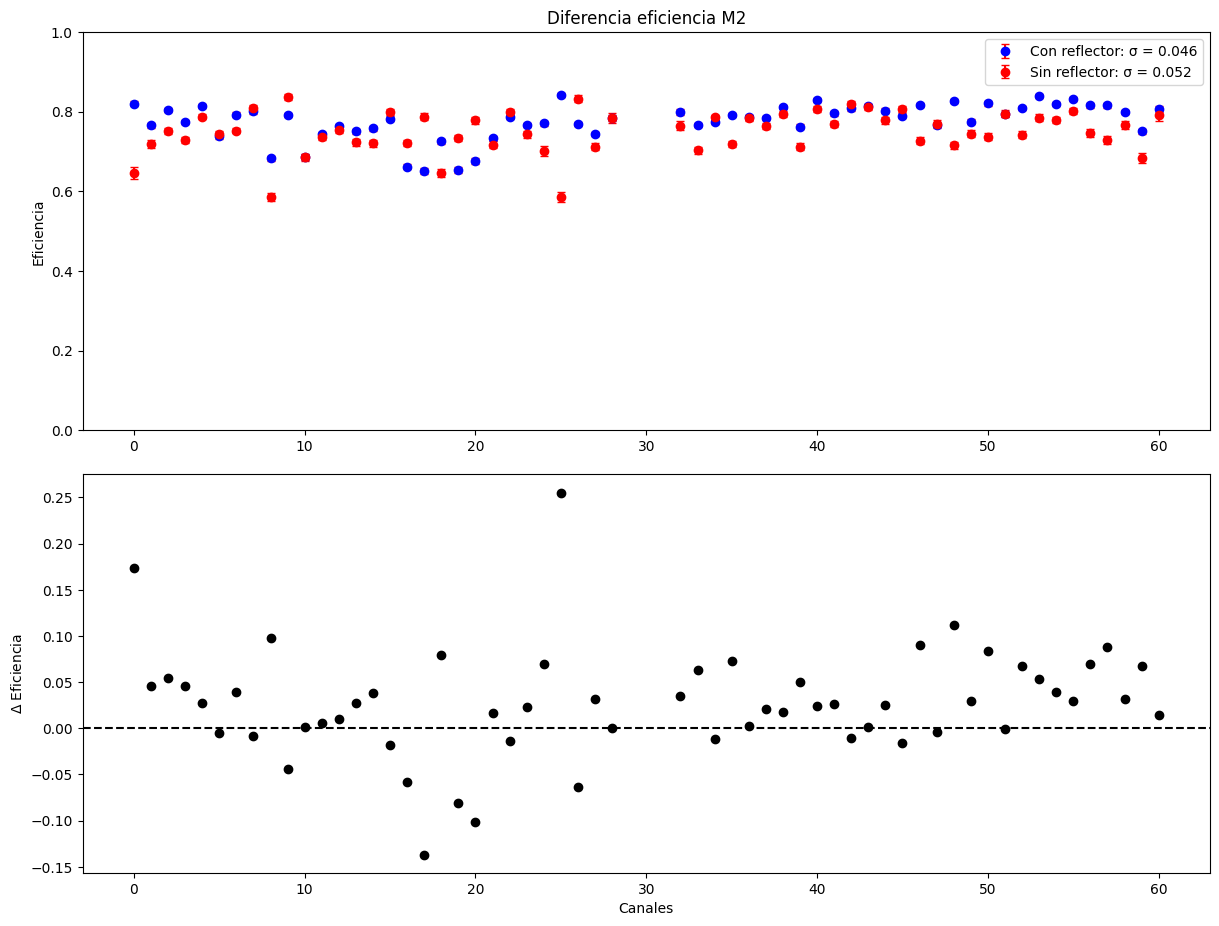

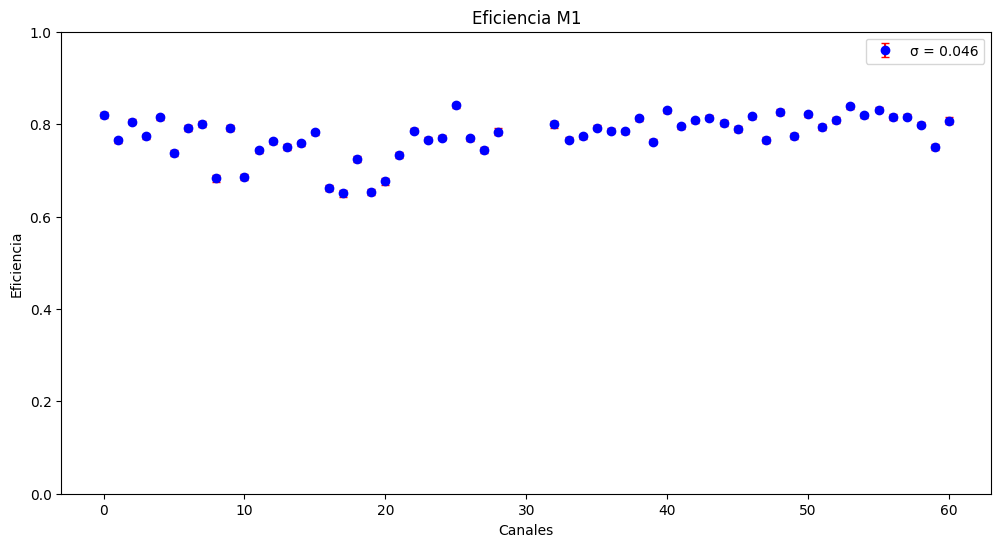

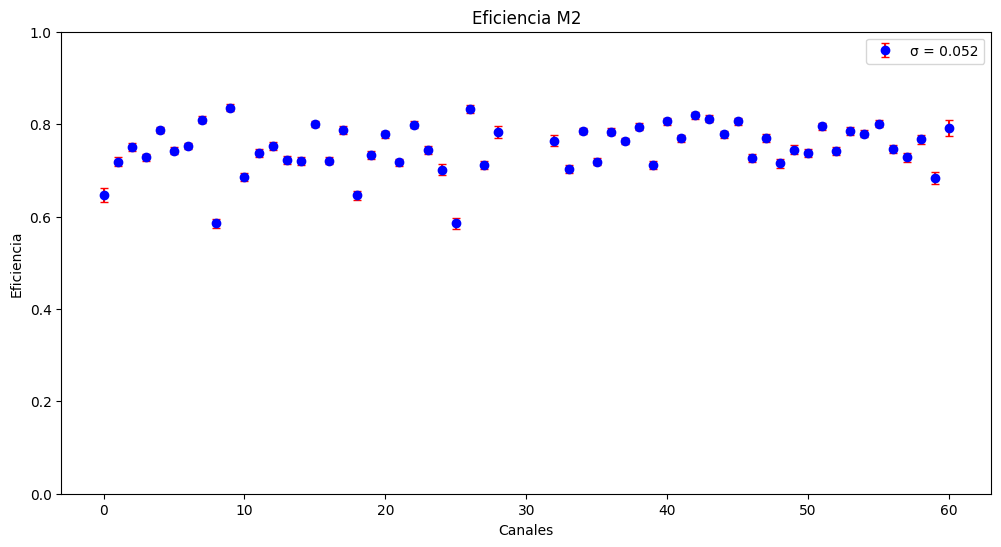

In [ ]:
cuadri_h = np.array(list(cuadruples_h.values()))
triple_h = np.array(list(triples_h.values()))
cuadri_l = np.array(list(cuadruples_l.values()))
triple_l = np.array(list(triples_l.values()))
cuadri_b = np.array(list(cuadruples_b.values()))
triple_b = np.array(list(triples_b.values()))

canales = list(triples_h.keys())

with np.errstate(divide='ignore', invalid='ignore'):
    efi_h = cuadri_h/(triple_h+cuadri_h)
    efi_l = cuadri_l/(triple_l+cuadri_l)
    efi_b = cuadri_b/(triple_b+cuadri_b)

    err_efi_h = np.sqrt(cuadri_h*((triple_h/(cuadri_h+triple_h)**2))**2 + triple_h*((cuadri_h/(cuadri_h+triple_h)**2))**2)
    err_efi_l = np.sqrt(cuadri_l*((triple_l/(cuadri_l+triple_l)**2))**2 + triple_l*((cuadri_l/(cuadri_l+triple_l)**2))**2)
    err_efi_b = np.sqrt(cuadri_b*((triple_b/(cuadri_b+triple_b)**2))**2 + triple_b*((cuadri_b/(cuadri_b+triple_b)**2))**2)
    
new_efi_h = efi_h[~np.isnan(efi_h)]
std_efi_h = np.std(new_efi_h)

new_efi_l = efi_l[~np.isnan(efi_l)]
std_efi_l = np.std(new_efi_l)

new_efi_b = efi_b[~np.isnan(efi_b)]
std_efi_b = np.std(new_efi_b)

# Calculo de una segunda prueba eficiencia para comparar
"""
cuadri_h2 = np.array(list(cuadruples_h2.values()))
triple_h2 = np.array(list(triples_h2.values()))
cuadri_l2 = np.array(list(cuadruples_l2.values()))
triple_l2 = np.array(list(triples_l2.values()))
cuadri_b2 = np.array(list(cuadruples_b2.values()))
triple_b2 = np.array(list(triples_b2.values()))

canales2 = list(triples_h2.keys())

with np.errstate(divide='ignore', invalid='ignore'):
    efi_h2 = cuadri_h2/(triple_h2+cuadri_h2)
    efi_l2 = cuadri_l2/(triple_l2+cuadri_l2)
    efi_b2 = cuadri_b2/(triple_b2+cuadri_b2)

    err_efi_h2 = np.sqrt(cuadri_h2*((triple_h2/(cuadri_h2+triple_h2)**2))**2 + triple_h2*((cuadri_h2/(cuadri_h2+triple_h2)**2))**2)
    err_efi_l2 = np.sqrt(cuadri_l2*((triple_l2/(cuadri_l2+triple_l2)**2))**2 + triple_l2*((cuadri_l2/(cuadri_l2+triple_l2)**2))**2)
    err_efi_b2 = np.sqrt(cuadri_b2*((triple_b2/(cuadri_b2+triple_b2)**2))**2 + triple_b2*((cuadri_b2/(cuadri_b2+triple_b2)**2))**2)
    
new_efi_h2 = efi_h2[~np.isnan(efi_h2)]
std_efi_h2 = np.std(new_efi_h2)

new_efi_l2 = efi_l2[~np.isnan(efi_l2)]
std_efi_l2 = np.std(new_efi_l2)

new_efi_b2 = efi_b2[~np.isnan(efi_b2)]
std_efi_b2 = np.std(new_efi_b2)

"""





#fig1, ax1 = plt.subplots(2, 1, figsize=(12, 9))
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
fig3, ax3 = plt.subplots(1, 1, figsize=(12, 6))


"""
ax1[0].errorbar(canales, efi_h, yerr=err_efi_h, fmt='o', color='blue', ecolor='red', capsize=3, label=f"Con reflector: σ = {round(std_efi_h,3)}")
ax1[0].errorbar(canales2, efi_h2, yerr=err_efi_h2, fmt='o', color='red', ecolor='red', capsize=3, label=f"Sin reflector: σ = {round(std_efi_h2,3)}")
ax1[0].set_title("Diferencia eficiencia M2")
ax1[0].set_ylabel("Eficiencia")
ax1[0].set_ylim(0,1)
ax1[0].legend()

ax1[1].scatter(canales2, efi_h-efi_h2, color='black')
ax1[1].axhline(y=0, color='black', linestyle='--')
ax1[1].set_xlabel("Canales")
ax1[1].set_ylabel(r"$\Delta$ Eficiencia")"""

ax2.errorbar(canales, efi_h, yerr=err_efi_h, fmt='o', color='blue', ecolor='red', capsize=3, label=f"σ = {round(std_efi_h,3)}")
ax2.set_title("Eficiencia M1")
ax2.set_xlabel("Canales")
ax2.set_ylabel("Eficiencia")
ax2.set_ylim(0,1)
ax2.legend()

"""ax3.errorbar(canales, efi_h2, yerr=err_efi_h2, fmt='o', color='blue', ecolor='red', capsize=3, label=f"σ = {round(std_efi_h2,3)}")
ax3.set_title("Eficiencia M2")
ax3.set_xlabel("Canales")
ax3.set_ylabel("Eficiencia")
ax3.set_ylim(0,1)
ax3.legend()"""
print(len(n_counts_h),len(n_counts_l), len(n_counts_b))